# Field4D 可視化チュートリアル

このノートブックでは、`Field4D` クラスの描画・解析機能を実践します。
コア機能については `intro_Field4D.ipynb` を参照してください。

## 学習内容
1. 2D断面マップ（`plot_map2d`）
2. 多点時系列の抽出と重ね書き（`plot_timeseries_points`）
3. 1D分布プロファイル（`plot_profile`）
4. 応用解析（`diff`, `zscore`, `time_stat_map`, `time_space_map`）


## セットアップ


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.types import Field4D

# 再現性のためのシード設定
rng = np.random.default_rng(seed=42)

# Matplotlib スタイル
plt.style.use('default')
%matplotlib inline

## 共通テストデータの生成

再現性と検証を容易にするため、**解析解を持つデータ**を使用します。
ここでは「移動するガウシアン」を生成します。


In [2]:
# 軸定義（等間隔・単位付き）
nt, nx, ny, nz = 20, 32, 32, 1  # nz=1 は2D空間として扱う
t = np.linspace(0, 1, nt) * u.s
x = np.linspace(-5, 5, nx) * u.m
y = np.linspace(-5, 5, ny) * u.m
z = np.array([0]) * u.m  # 2D case

# メッシュグリッド
T, X, Y = np.meshgrid(t.value, x.value, y.value, indexing='ij')

# 移動ガウシアン: 中心が時間とともにx方向に移動
x_center = T * 5  # 5 m/s で移動
sigma = 1.0  # ガウスの幅
amplitude = 10.0  # 振幅

data = amplitude * np.exp(-((X - x_center)**2 + Y**2) / (2 * sigma**2))
data = data[:, :, :, np.newaxis]  # (t, x, y, z=1)

# Field4D オブジェクトの作成
field = Field4D(
    data,
    unit=u.V,
    axis0=t,
    axis1=x,
    axis2=y,
    axis3=z,
    axis_names=['t', 'x', 'y', 'z'],
    axis0_domain='time',
    space_domain='real'
)

print(f'Shape: {field.shape}')
print(f'Unit: {field.unit}')
print(f'Time range: {t[0]} - {t[-1]}')

Shape: (20, 32, 32, 1)
Unit: V
Time range: 0.0 s - 1.0 s


## 1. 2D断面マップ（`plot_map2d`）

4Dフィールドから特定の時刻・位置でスライスし、2Dヒートマップを描画します。


/tmp/ipykernel_2244596/2496369961.py:4: UserWarning: Glyph 26029 (\N{CJK UNIFIED IDEOGRAPH-65AD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/2496369961.py:4: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


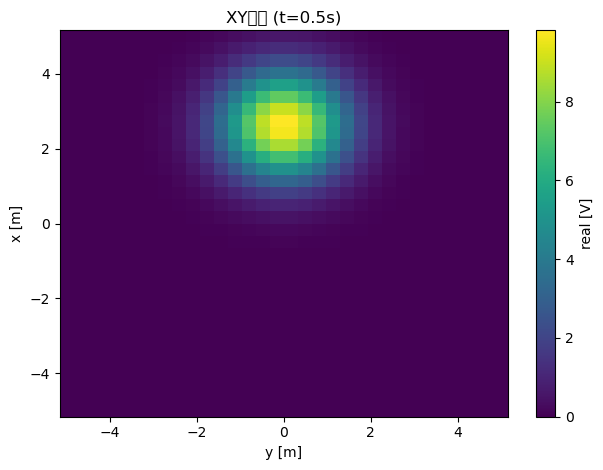

In [3]:
# t=0.5s における XY 断面
fig, ax = field.plot_map2d('xy', at={'t': 0.5 * u.s}, add_colorbar=True)
ax.set_title('XY断面 (t=0.5s)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_2244596/1457208419.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


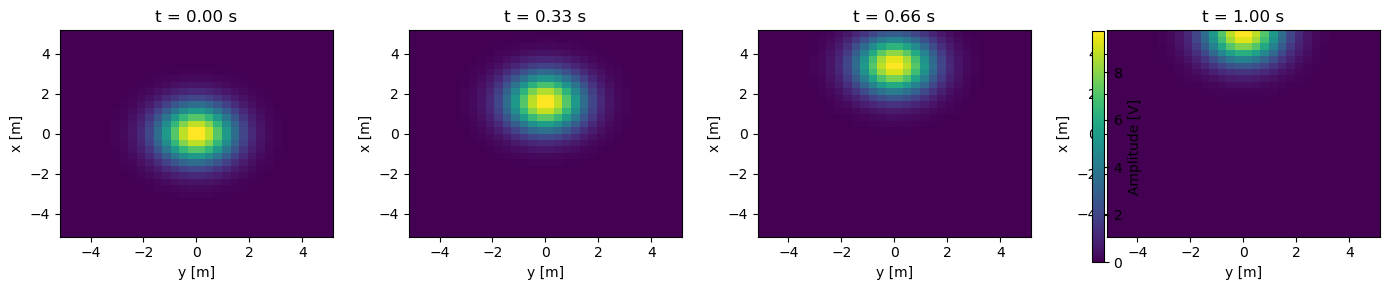

In [4]:
# 複数時刻の断面を比較
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for i, t_val in enumerate([0.0, 0.33, 0.66, 1.0]):
    _, ax = field.plot_map2d('xy', at={'t': t_val * u.s}, ax=axes[i], add_colorbar=False)
    ax.set_title(f't = {t_val:.2f} s')

fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', label='Amplitude [V]')
plt.tight_layout()
plt.show()

## 2. 多点時系列の抽出と重ね書き

複数の空間点における時系列を抽出し、`plot_timeseries_points` で重ねて描画します。


/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1210920687.py:11: UserWarning: Glyph 21015 (\N{CJK UNIFIED ID

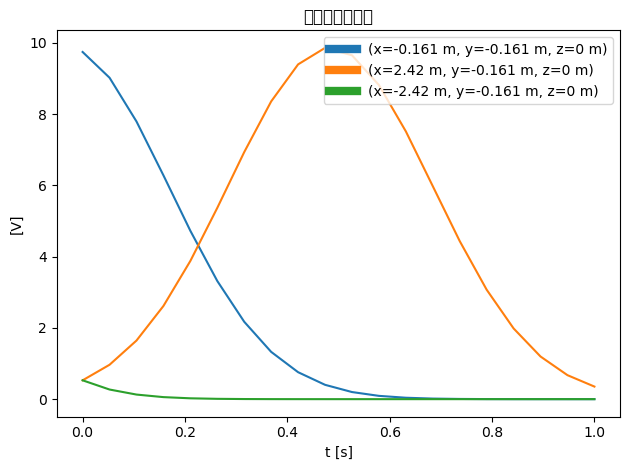

In [5]:
# 複数点を定義
points = [
    (0.0 * u.m, 0.0 * u.m, 0.0 * u.m),   # 中心
    (2.5 * u.m, 0.0 * u.m, 0.0 * u.m),  # 右側
    (-2.5 * u.m, 0.0 * u.m, 0.0 * u.m), # 左側
]

fig, ax = field.plot_timeseries_points(points)
ax.set_title('複数点の時系列')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 3. 1D分布プロファイル

指定した軸に沿った断面プロファイルを `plot_profile` で描画します。


/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 36600 (\N{CJK UNIFIED IDEOGRAPH-8EF8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1848724536.py:4: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu 

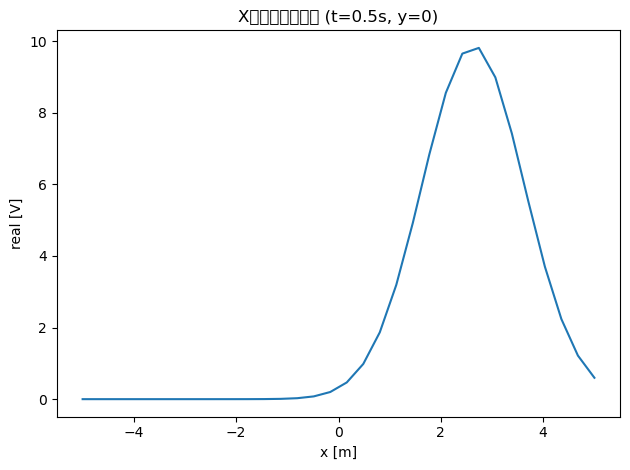

In [6]:
# t=0.5s, y=0 における X軸方向プロファイル
fig, ax = field.plot_profile('x', at={'t': 0.5 * u.s, 'y': 0.0 * u.m, 'z': 0.0 * u.m})
ax.set_title('X軸プロファイル (t=0.5s, y=0)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 12372 (\N{HIRAGANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 36600 (\N{CJK UNIFIED IDEOGRAPH-8EF8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/3331576732.py:13: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing f

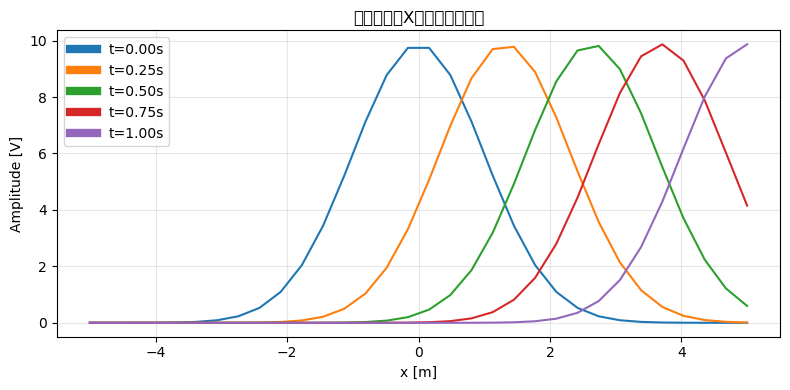

In [7]:
# 時刻ごとのプロファイル重ね書き
fig, ax = plt.subplots(figsize=(8, 4))

for t_val in [0.0, 0.25, 0.5, 0.75, 1.0]:
    axis_index, profile_data = field.extract_profile('x', at={'t': t_val * u.s, 'y': 0.0 * u.m, 'z': 0.0 * u.m})
    ax.plot(axis_index.value, profile_data.squeeze(), label=f't={t_val:.2f}s')

ax.set_xlabel('x [m]')
ax.set_ylabel('Amplitude [V]')
ax.set_title('時刻ごとのX軸プロファイル')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. 応用解析機能

`Field4D` が持つ解析メソッドを使って、より高度な可視化を行います。


### 4.1 差分と比率（`diff`）


/tmp/ipykernel_2244596/2041495896.py:18: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/2041495896.py:18: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


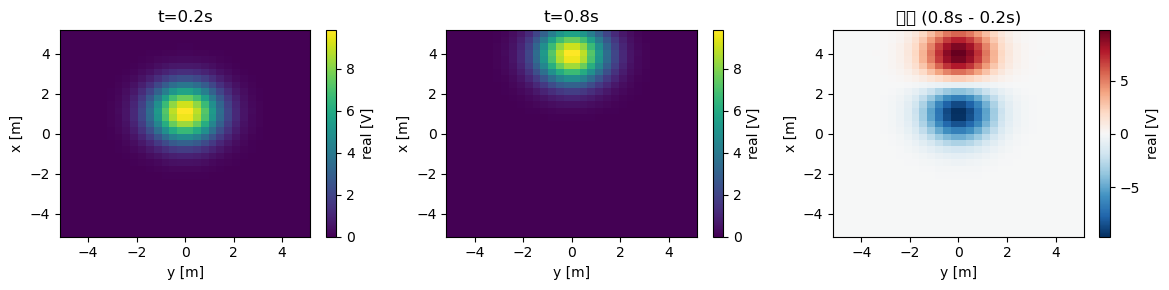

In [8]:
# 異なる2時刻のフィールドをスライスして差分を計算
slice_early = field.slice_map2d('xy', at={'t': 0.2 * u.s})
slice_late = field.slice_map2d('xy', at={'t': 0.8 * u.s})

diff_field = slice_late.diff(slice_early, mode='diff')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

slice_early.plot_map2d('xy', ax=axes[0], add_colorbar=True)
axes[0].set_title('t=0.2s')

slice_late.plot_map2d('xy', ax=axes[1], add_colorbar=True)
axes[1].set_title('t=0.8s')

diff_field.plot_map2d('xy', ax=axes[2], add_colorbar=True, cmap='RdBu_r')
axes[2].set_title('差分 (0.8s - 0.2s)')

plt.tight_layout()
plt.show()

### 4.2 Z-score 正規化


/tmp/ipykernel_2244596/1496327938.py:12: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1496327938.py:12: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1496327938.py:12: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/1496327938.py:12: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


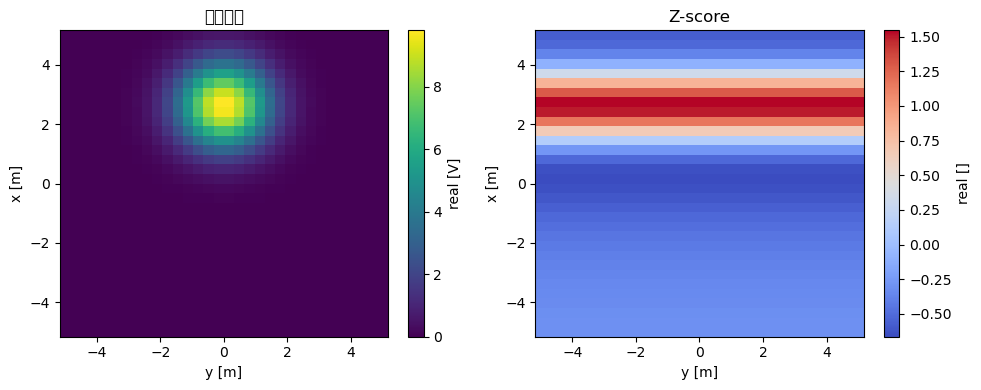

Z-score unit: 


In [9]:
# 全時間軸を使ってz-scoreを計算
field_zscore = field.zscore()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

field.plot_map2d('xy', at={'t': 0.5 * u.s}, ax=axes[0], add_colorbar=True)
axes[0].set_title('元データ')

field_zscore.plot_map2d('xy', at={'t': 0.5 * u.s}, ax=axes[1], add_colorbar=True, cmap='coolwarm')
axes[1].set_title('Z-score')

plt.tight_layout()
plt.show()

print(f'Z-score unit: {field_zscore.unit}')

### 4.3 時間要約マップ（`time_stat_map`）


/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/213198805.py:17: UserWarning: Glyph 20516 (\N{CJK UNIFIED I

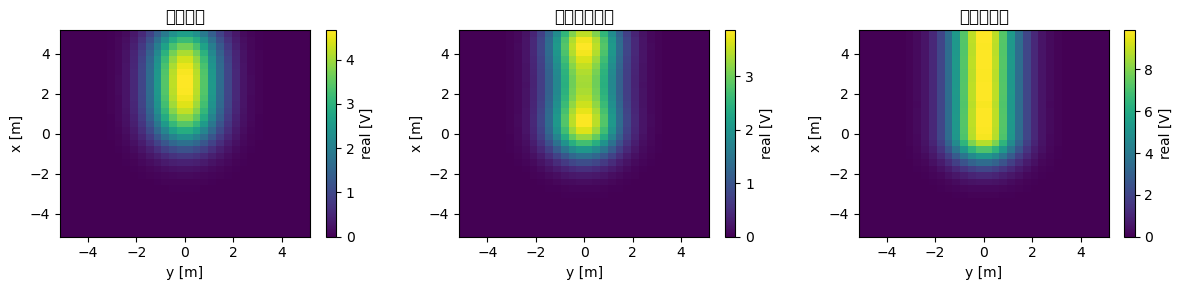

In [10]:
# 時間方向の統計量を計算
mean_map = field.time_stat_map(stat='mean')
std_map = field.time_stat_map(stat='std')
max_map = field.time_stat_map(stat='max')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

mean_map.plot_map2d('xy', ax=axes[0], add_colorbar=True)
axes[0].set_title('時間平均')

std_map.plot_map2d('xy', ax=axes[1], add_colorbar=True)
axes[1].set_title('時間標準偏差')

max_map.plot_map2d('xy', ax=axes[2], add_colorbar=True)
axes[2].set_title('時間最大値')

plt.tight_layout()
plt.show()

### 4.4 時間-空間マップ（`plot_time_space_map`）

時間軸と1つの空間軸を使った2Dマップ（ストリークカメラ的な表示）です。


/tmp/ipykernel_2244596/792093913.py:4: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/792093913.py:4: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/792093913.py:4: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/792093913.py:4: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2244596/792093913.py:4: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


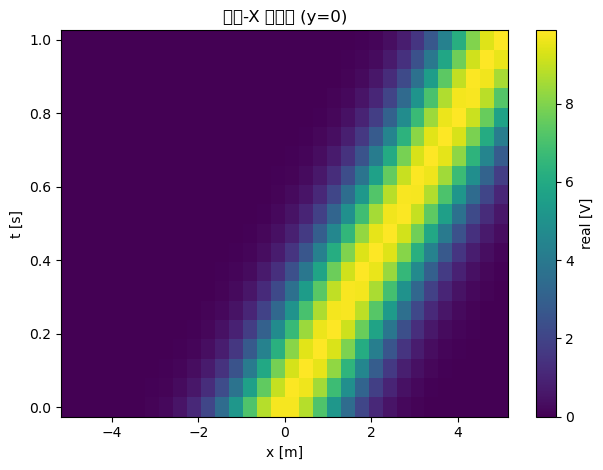

In [11]:
# y=0 における時間-x マップ
fig, ax = field.plot_time_space_map('x', at={'y': 0.0 * u.m}, add_colorbar=True)
ax.set_title('時間-X マップ (y=0)')
plt.tight_layout()
plt.show()

## まとめ

このノートブックでは、`Field4D` の可視化機能を学びました：

1. **2D断面マップ**: `plot_map2d` で任意の平面を可視化
2. **時系列抽出**: `extract_points` + `plot_timeseries_points` で複数点を比較
3. **1Dプロファイル**: `extract_profile` + `plot_profile` で断面分布を確認
4. **応用解析**: `diff`, `zscore`, `time_stat_map`, `time_space_map` による高度な解析

これらを組み合わせることで、4次元時空間データの包括的な可視化が可能です。
